In [37]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from ripser import lower_star_img
from ripser import Rips
vr = Rips()

from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_circles
from sklearn.manifold import MDS

import pickle
from tqdm import tqdm

from modules import TransformerEncoder, MLPDecoder, MLPEncoder
from model import AutoEncoderModel

import torch
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
def generate_orbit(point_0, r, n=300):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=300, random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j])
            
    return orbits

In [4]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, random_state=random_state)

In [5]:
y = np.zeros(1000)

for i in range(1, 5):
    y = np.concatenate((y, np.ones(1000) * i))

In [6]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))
    pd_no_zero_dim = np.zeros((0, 3))
    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))
        if k != 0:
            pd_no_zero_dim = np.concatenate((pd_no_zero_dim, diagram_k))

    return pd, pd_no_zero_dim

In [7]:
X = []
X_no_zero_dim = []
for x_pc in tqdm(X_orbit5k):
    diagram, diagram_no_zero_dim = conv_pd(vr.fit_transform(x_pc))
    X.append(diagram)
    X_no_zero_dim.append(diagram_no_zero_dim)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:14<00:00, 19.67it/s]


In [28]:
class Orbit5kDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_fn(data):
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    mask = np.zeros((n_batch, n_points_pd))
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
        mask[i][:len(pd)] = 1
    
    return torch.Tensor(inputs_pd), torch.Tensor(mask), torch.Tensor(labels).long()

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = Orbit5kDataset(X, y)
n_train, n_test = 3500, 1500
batch_size = 64
dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [34]:
model_classificator = TransformerEncoder(n_in=3, embed_dim=32, fc_dim=32, num_heads=4, num_layers=2, n_out_enc=5,
                            reduction="attention")
checkpoint = torch.load("persformer_orbit5k_76_test_acc.pt", map_location=torch.device('cpu'))
model_classificator.load_state_dict(checkpoint)

<All keys matched successfully>

In [51]:
encoder = MLPEncoder(n_in=3, n_hidden=16, num_layers=2, n_out=8)
decoder = MLPDecoder(n_in=8, n_hidden=16, num_layers=2, n_out=3*387, set_channels=3)


model_approximator = AutoEncoderModel(encoder=encoder, decoder=decoder)

checkpoint = torch.load("linear_baseline_ae.pt", map_location=torch.device('cpu'))
model_approximator.load_state_dict(checkpoint)

<All keys matched successfully>

  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

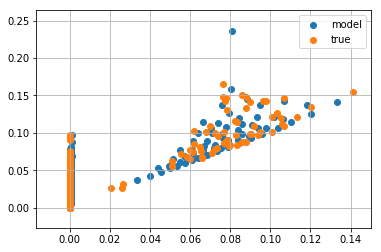

  2%|█▌                                                                                 | 1/55 [00:02<02:39,  2.95s/it]

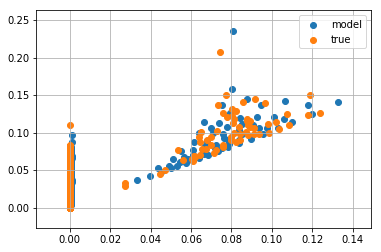

  4%|███                                                                                | 2/55 [00:05<02:35,  2.93s/it]

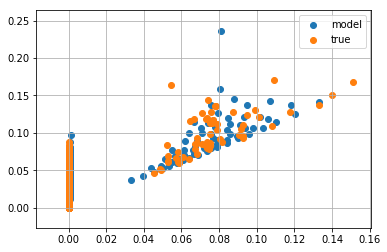

  5%|████▌                                                                              | 3/55 [00:08<02:27,  2.84s/it]

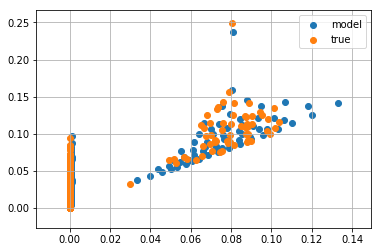

  7%|██████                                                                             | 4/55 [00:11<02:22,  2.79s/it]

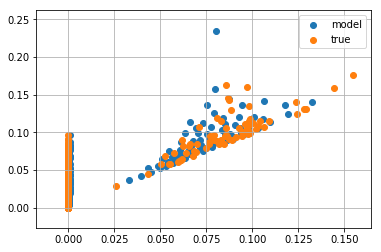

  9%|███████▌                                                                           | 5/55 [00:14<02:24,  2.88s/it]

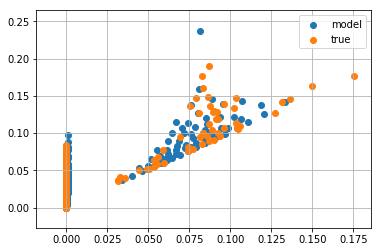

 11%|█████████                                                                          | 6/55 [00:17<02:22,  2.91s/it]

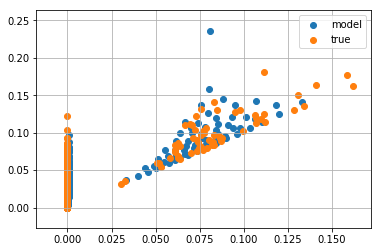

 13%|██████████▌                                                                        | 7/55 [00:20<02:28,  3.10s/it]

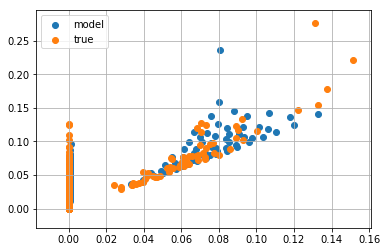

 15%|████████████                                                                       | 8/55 [00:23<02:22,  3.02s/it]

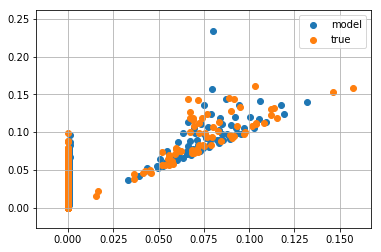

 16%|█████████████▌                                                                     | 9/55 [00:26<02:16,  2.96s/it]

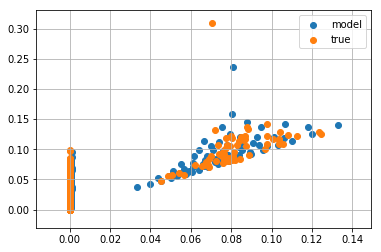

 18%|██████████████▉                                                                   | 10/55 [00:29<02:10,  2.89s/it]

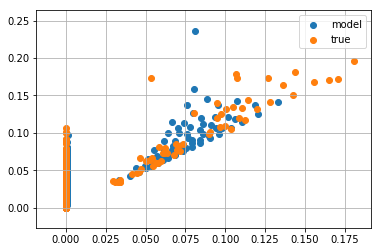

 20%|████████████████▍                                                                 | 11/55 [00:32<02:05,  2.85s/it]

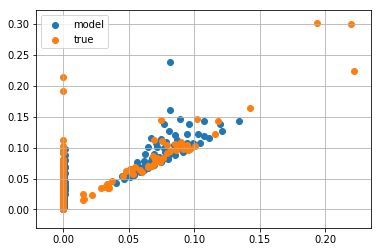

 22%|█████████████████▉                                                                | 12/55 [00:34<02:03,  2.87s/it]

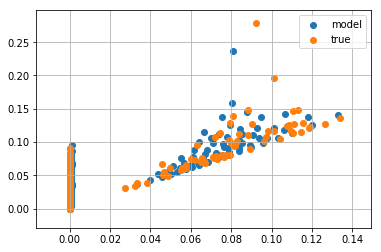

 24%|███████████████████▍                                                              | 13/55 [00:37<01:59,  2.85s/it]

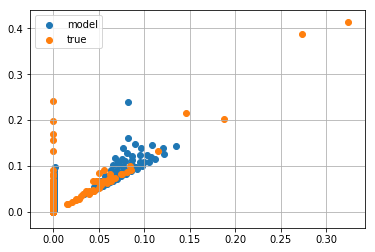

 25%|████████████████████▊                                                             | 14/55 [00:40<01:54,  2.80s/it]

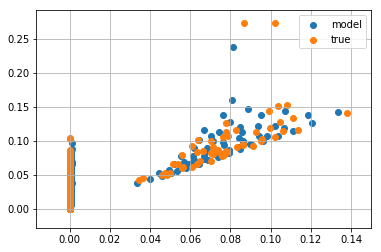

 27%|██████████████████████▎                                                           | 15/55 [00:43<01:51,  2.79s/it]

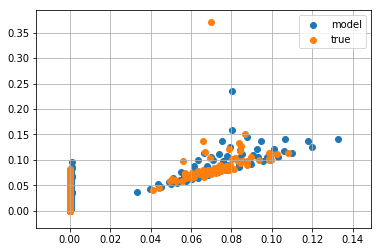

 29%|███████████████████████▊                                                          | 16/55 [00:45<01:48,  2.79s/it]

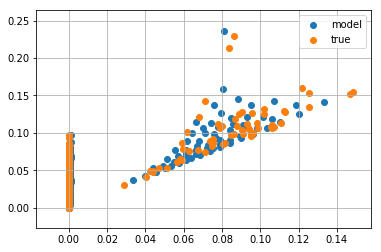

 31%|█████████████████████████▎                                                        | 17/55 [00:49<01:57,  3.09s/it]

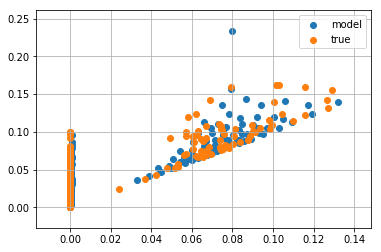

 33%|██████████████████████████▊                                                       | 18/55 [00:54<02:15,  3.66s/it]

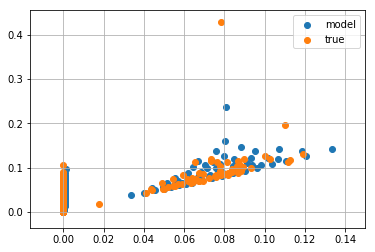

 35%|████████████████████████████▎                                                     | 19/55 [00:57<02:07,  3.54s/it]

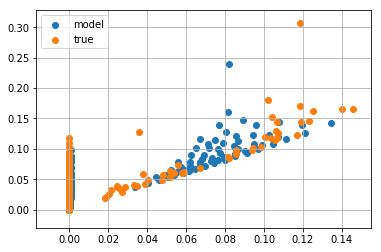

 36%|█████████████████████████████▊                                                    | 20/55 [01:01<01:58,  3.38s/it]

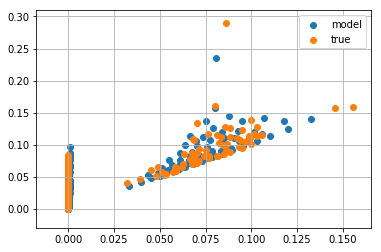

 38%|███████████████████████████████▎                                                  | 21/55 [01:04<01:53,  3.35s/it]

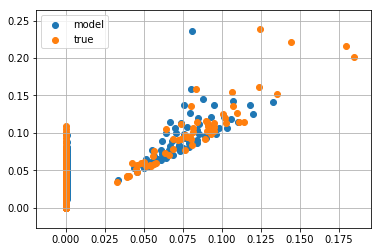

 40%|████████████████████████████████▊                                                 | 22/55 [01:08<01:55,  3.51s/it]

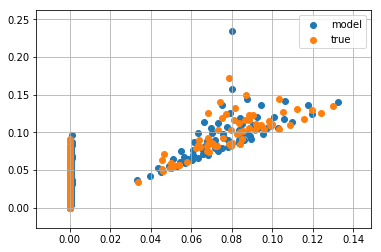

 42%|██████████████████████████████████▎                                               | 23/55 [01:11<01:46,  3.33s/it]

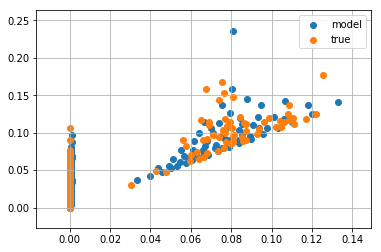

 44%|███████████████████████████████████▊                                              | 24/55 [01:13<01:38,  3.18s/it]

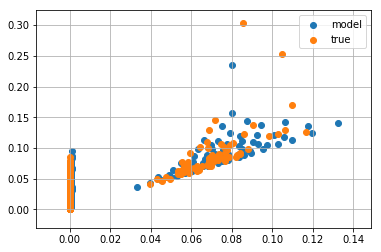

 45%|█████████████████████████████████████▎                                            | 25/55 [01:16<01:32,  3.07s/it]

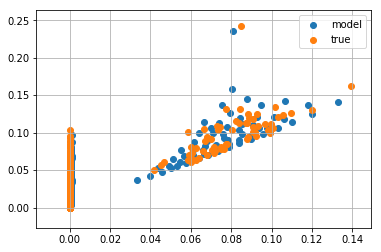

 47%|██████████████████████████████████████▊                                           | 26/55 [01:19<01:26,  2.99s/it]

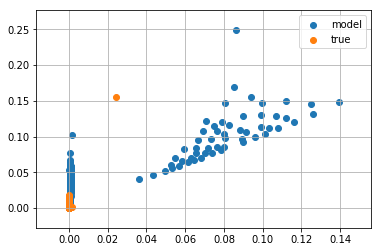

 49%|████████████████████████████████████████▎                                         | 27/55 [01:22<01:21,  2.92s/it]

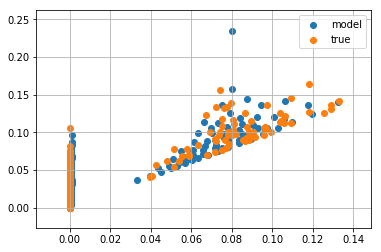

 51%|█████████████████████████████████████████▋                                        | 28/55 [01:25<01:19,  2.94s/it]

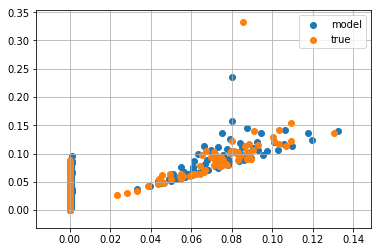

 53%|███████████████████████████████████████████▏                                      | 29/55 [01:28<01:16,  2.94s/it]

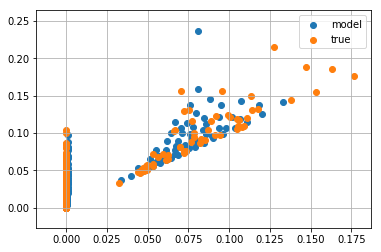

 55%|████████████████████████████████████████████▋                                     | 30/55 [01:31<01:13,  2.93s/it]

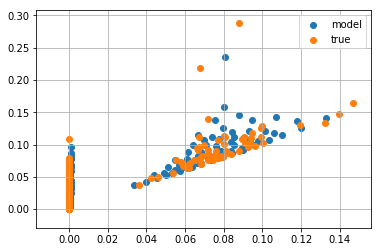

 56%|██████████████████████████████████████████████▏                                   | 31/55 [01:33<01:09,  2.89s/it]

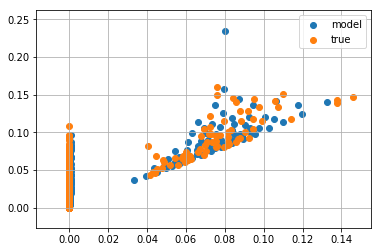

 58%|███████████████████████████████████████████████▋                                  | 32/55 [01:36<01:05,  2.84s/it]

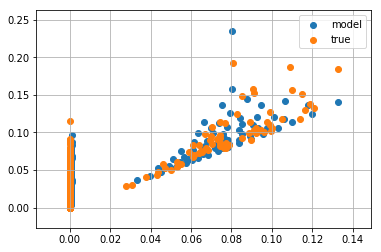

 60%|█████████████████████████████████████████████████▏                                | 33/55 [01:39<01:01,  2.81s/it]

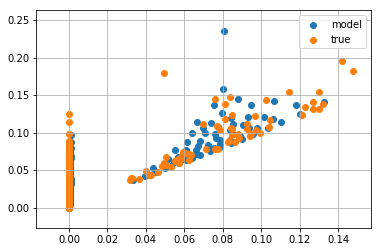

 62%|██████████████████████████████████████████████████▋                               | 34/55 [01:42<00:58,  2.80s/it]

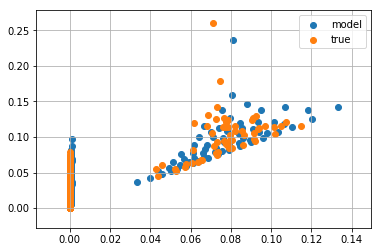

 64%|████████████████████████████████████████████████████▏                             | 35/55 [01:44<00:55,  2.77s/it]

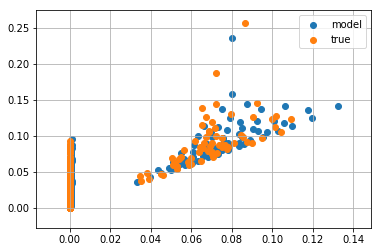

 65%|█████████████████████████████████████████████████████▋                            | 36/55 [01:47<00:52,  2.74s/it]

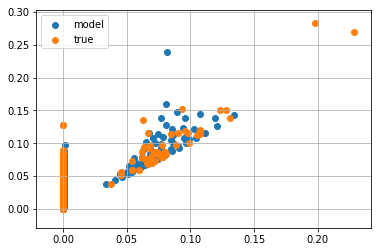

 67%|███████████████████████████████████████████████████████▏                          | 37/55 [01:50<00:50,  2.78s/it]

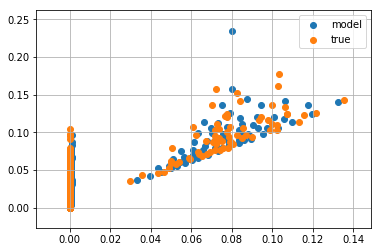

 69%|████████████████████████████████████████████████████████▋                         | 38/55 [01:53<00:46,  2.74s/it]

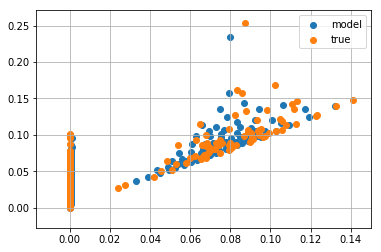

 71%|██████████████████████████████████████████████████████████▏                       | 39/55 [01:55<00:44,  2.75s/it]

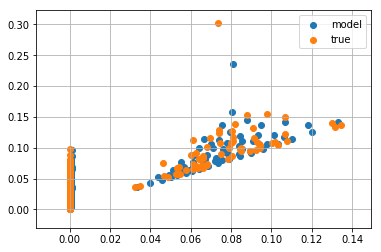

 73%|███████████████████████████████████████████████████████████▋                      | 40/55 [01:58<00:42,  2.82s/it]

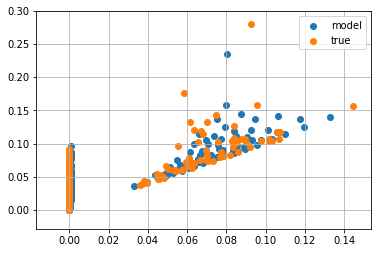

 75%|█████████████████████████████████████████████████████████████▏                    | 41/55 [02:01<00:39,  2.80s/it]

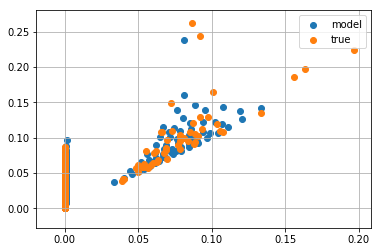

 76%|██████████████████████████████████████████████████████████████▌                   | 42/55 [02:04<00:36,  2.80s/it]

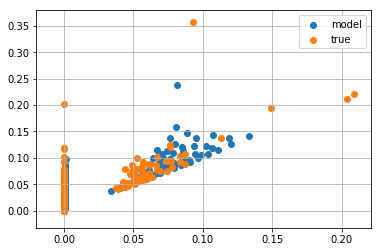

 78%|████████████████████████████████████████████████████████████████                  | 43/55 [02:07<00:33,  2.81s/it]

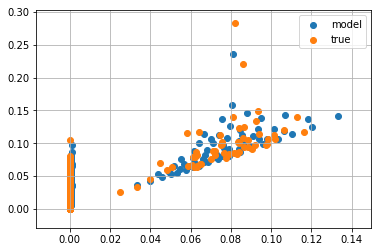

 80%|█████████████████████████████████████████████████████████████████▌                | 44/55 [02:09<00:30,  2.80s/it]

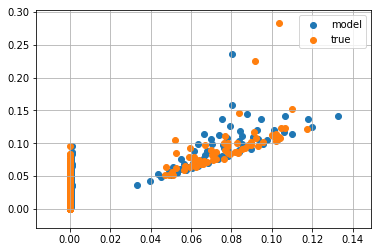

 82%|███████████████████████████████████████████████████████████████████               | 45/55 [02:12<00:28,  2.83s/it]

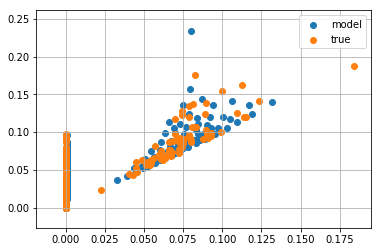

 84%|████████████████████████████████████████████████████████████████████▌             | 46/55 [02:15<00:25,  2.88s/it]

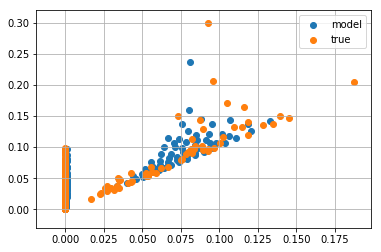

 85%|██████████████████████████████████████████████████████████████████████            | 47/55 [02:19<00:23,  2.98s/it]

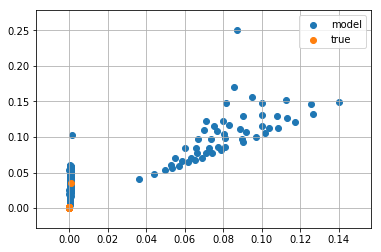

 87%|███████████████████████████████████████████████████████████████████████▌          | 48/55 [02:22<00:21,  3.02s/it]

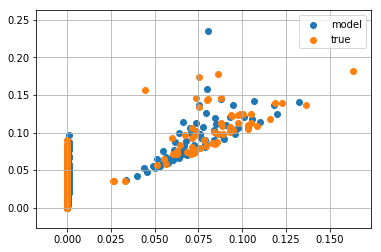

 89%|█████████████████████████████████████████████████████████████████████████         | 49/55 [02:25<00:17,  2.97s/it]

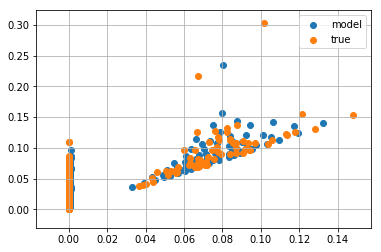

 91%|██████████████████████████████████████████████████████████████████████████▌       | 50/55 [02:27<00:14,  2.90s/it]

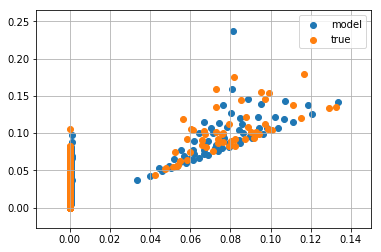

 93%|████████████████████████████████████████████████████████████████████████████      | 51/55 [02:30<00:11,  2.84s/it]

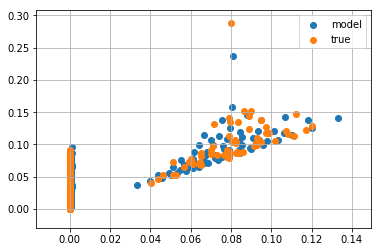

 95%|█████████████████████████████████████████████████████████████████████████████▌    | 52/55 [02:33<00:08,  2.83s/it]

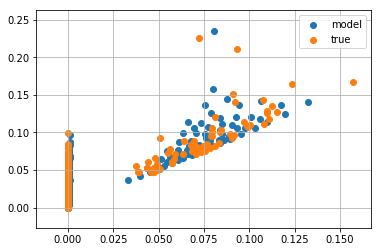

 96%|███████████████████████████████████████████████████████████████████████████████   | 53/55 [02:36<00:05,  2.91s/it]

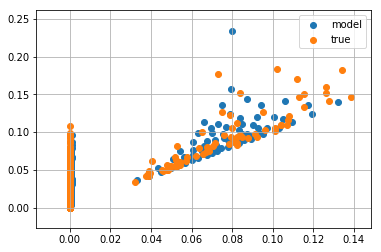

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 54/55 [02:39<00:02,  2.87s/it]

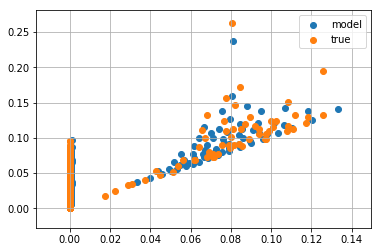

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [02:41<00:00,  2.93s/it]


0.772 0.19857142857142857


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:02<00:00,  2.60s/it]

0.7573333333333333 0.20266666666666666


In [53]:
#linear baseline
model_classificator.eval()
model_approximator.eval()

correct, correct_approx = 0, 0
for batch in tqdm(dataloader_train):
    y_hat = model_classificator(batch[0].to(device), batch[1].to(device)).argmax(dim=1)
    correct += int((y_hat == batch[2].to(device)).sum())
    
    batch[0][:, :, 1] -= batch[0][:, :, 0]
    
    predicted_diagrams = model_approximator(batch[0].to(device), batch[1].long().to(device))
    predicted_diagrams[:, :, 2] = predicted_diagrams[:, :, 2] > 0.5
    predicted_diagrams[:, :, 1] += predicted_diagrams[:, :, 0]
    
    batch[0][:, :, 1] += batch[0][:, :, 0]
    
    #print(predicted_diagrams[0])
    plt.scatter(predicted_diagrams[0, :, 0].detach().numpy(), predicted_diagrams[0, :, 1].detach().numpy(), label='model')
    plt.scatter(batch[0][0, :, 0].detach().numpy(), batch[0][0, :, 1].detach().numpy(), label='true')
    plt.grid()
    plt.legend()
    plt.show()
    
    y_hat_approx = model_classificator(predicted_diagrams, batch[1].to(device)).argmax(dim=1)
    correct_approx += int((y_hat_approx == batch[2].to(device)).sum())
    
accuracy_train = correct / len(dataloader_train.dataset)
accuracy_train_approx = correct_approx / len(dataloader_train.dataset)
print(accuracy_train, accuracy_train_approx)

correct, correct_approx = 0, 0
for batch in tqdm(dataloader_test):
    y_hat = model_classificator(batch[0].to(device), batch[1].to(device)).argmax(dim=1)
    correct += int((y_hat == batch[2].to(device)).sum())
    
    batch[0][:, :, 1] -= batch[0][:, :, 0]
    predicted_diagrams = model_approximator(batch[0].to(device), batch[1].long().to(device))
    predicted_diagrams[:, :, 2] = predicted_diagrams[:, :, 2] > 0.5
    predicted_diagrams[:, :, 1] += predicted_diagrams[:, :, 0]
    
    batch[0][:, :, 1] += batch[0][:, :, 0]
    
    y_hat_approx = model_classificator(predicted_diagrams, batch[1].to(device)).argmax(dim=1)
    correct_approx += int((y_hat_approx == batch[2].to(device)).sum())
    
accuracy_test = correct / len(dataloader_test.dataset)
accuracy_test_approx = correct_approx / len(dataloader_test.dataset)
print(accuracy_test, accuracy_test_approx)

In [ ]:
encoder = TransformerEncoder(n_in=set_channels, embed_dim=32, fc_dim=64, num_heads=4, num_layers=3, n_out_enc=50,
                            reduction="attention")
generator = TopNGenerator(set_channels=3, cosine_channels=8, max_n=n_max, latent_dim=50)
decoder = TransformerDecoder(n_in=3, latent_dim=50, fc_dim=128, num_heads=4, num_layers=3, n_out=3, generator=generator, 
                 n_out_lin=64, n_hidden=128, num_layers_lin = 2, dropout = 0.1, use_conv=True)

model_approximator = AutoEncoderModel(encoder, decoder).to(device)

checkpoint = torch.load("persformer_topn_tspn_slwv1.pt", map_location=torch.device('cpu'))
model_approximator.load_state_dict(checkpoint)

In [ ]:

model_classificator.eval()
model_approximator.eval()

correct, correct_approx = 0, 0
for batch in tqdm(dataloader_train):
    y_hat = model_classificator(batch[0].to(device), batch[1].to(device)).argmax(dim=1)
    correct += int((y_hat == batch[2].to(device)).sum())
    
    batch[0][:, :, 1] -= batch[0][:, :, 0]
    
    predicted_diagrams = model_approximator(batch[0].to(device), batch[1].long().to(device))
    predicted_diagrams[:, :, 2] = predicted_diagrams[:, :, 2] > 0.5
    predicted_diagrams[:, :, 1] += predicted_diagrams[:, :, 0]
    
    batch[0][:, :, 1] += batch[0][:, :, 0]
    
    #print(predicted_diagrams[0])
    plt.scatter(predicted_diagrams[0, :, 0].detach().numpy(), predicted_diagrams[0, :, 1].detach().numpy(), label='model')
    plt.scatter(batch[0][0, :, 0].detach().numpy(), batch[0][0, :, 1].detach().numpy(), label='true')
    plt.grid()
    plt.legend()
    plt.show()
    
    y_hat_approx = model_classificator(predicted_diagrams, batch[1].to(device)).argmax(dim=1)
    correct_approx += int((y_hat_approx == batch[2].to(device)).sum())
    
accuracy_train = correct / len(dataloader_train.dataset)
accuracy_train_approx = correct_approx / len(dataloader_train.dataset)
print(accuracy_train, accuracy_train_approx)

correct, correct_approx = 0, 0
for batch in tqdm(dataloader_test):
    y_hat = model_classificator(batch[0].to(device), batch[1].to(device)).argmax(dim=1)
    correct += int((y_hat == batch[2].to(device)).sum())
    
    batch[0][:, :, 1] -= batch[0][:, :, 0]
    predicted_diagrams = model_approximator(batch[0].to(device), batch[1].long().to(device))
    predicted_diagrams[:, :, 2] = predicted_diagrams[:, :, 2] > 0.5
    predicted_diagrams[:, :, 1] += predicted_diagrams[:, :, 0]
    
    batch[0][:, :, 1] += batch[0][:, :, 0]
    
    y_hat_approx = model_classificator(predicted_diagrams, batch[1].to(device)).argmax(dim=1)
    correct_approx += int((y_hat_approx == batch[2].to(device)).sum())
    
accuracy_test = correct / len(dataloader_test.dataset)
accuracy_test_approx = correct_approx / len(dataloader_test.dataset)
print(accuracy_test, accuracy_test_approx)

In [23]:
%%time
n_repeats = 1
n_epochs = 500
batch_size = 64
lr = 0.001

n_train, n_test = 3500, 1500

history = np.zeros((n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit5kDataset(X, y)

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    # model init
    model = DeepSets(n_in=3, n_hidden_enc=16, n_out_enc=8, n_out_dec=5)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        model.train()
        
        loss_epoch = []
        for batch in dataloader_train:
            loss_batch = criterion(model(batch[0]), batch[1])
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch.append(loss_batch.detach())
        
        loss_epoch_mean = np.array(loss_epoch).mean()
        history[repeat_idx,epoch_idx,0] = loss_epoch_mean
        
        # test
        model.eval()
        
        correct = 0
        for batch in dataloader_train:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_train = correct / len(dataloader_train.dataset)
        history[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        for batch in dataloader_test:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_test = correct / len(dataloader_test.dataset)
        history[repeat_idx,epoch_idx,2] = accuracy_test
        
        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

  0 Loss   Train  Test  
  0 1.6128 0.2035 0.1860
  1 1.6099 0.2035 0.1860
  2 1.6093 0.2037 0.1880
  3 1.6090 0.2155 0.2000
  4 1.6083 0.2082 0.1920
  5 1.6075 0.2092 0.1930
  6 1.6064 0.2607 0.2320
  7 1.6042 0.2185 0.2210
  8 1.6006 0.2203 0.2170
  9 1.5956 0.2530 0.2340
 10 1.5882 0.2667 0.2290
 11 1.5787 0.2610 0.2560
 12 1.5684 0.2875 0.2580
 13 1.5574 0.2858 0.2750
 14 1.5438 0.2810 0.2760
 15 1.5339 0.3018 0.2880
 16 1.5244 0.3028 0.2850
 17 1.5178 0.2908 0.2720
 18 1.5122 0.2920 0.2700
 19 1.5159 0.2975 0.2840
 20 1.5056 0.2925 0.2720
 21 1.5044 0.2988 0.2810
 22 1.5012 0.2910 0.2630
 23 1.5032 0.2928 0.2630
 24 1.4988 0.2940 0.2840
 25 1.4985 0.2868 0.2640
 26 1.4945 0.2955 0.2750
 27 1.4953 0.2920 0.2680
 28 1.4916 0.2948 0.2590
 29 1.4905 0.2988 0.2690
 30 1.4886 0.3020 0.2710
 31 1.4882 0.2742 0.2730
 32 1.4879 0.2938 0.2740
 33 1.4864 0.3167 0.2800
 34 1.4844 0.2978 0.2810
 35 1.4838 0.3130 0.2730
 36 1.4837 0.3115 0.2810
 37 1.4834 0.3167 0.2810
 38 1.4832 0.3205 0.2810


327 1.2805 0.4435 0.4080
328 1.2807 0.4373 0.4030
329 1.2808 0.4340 0.4070
330 1.2775 0.4283 0.3880
331 1.2804 0.4397 0.4130
332 1.2838 0.4455 0.4120
333 1.2772 0.4355 0.4110
334 1.2767 0.4373 0.4010
335 1.2850 0.4385 0.4020
336 1.3012 0.4370 0.4020
337 1.2725 0.4442 0.4050
338 1.2825 0.4400 0.4090
339 1.2808 0.4363 0.4130
340 1.2722 0.4328 0.4130
341 1.2783 0.4340 0.4110
342 1.2859 0.4315 0.4070
343 1.2786 0.4365 0.4130
344 1.2727 0.4340 0.3980
345 1.2797 0.4420 0.4070
346 1.2765 0.4233 0.4070
347 1.2878 0.4363 0.4070
348 1.2879 0.4373 0.4050
349 1.2735 0.4410 0.4160
350 1.2774 0.4390 0.4080
351 1.2744 0.4390 0.4080
352 1.2823 0.4387 0.4080
353 1.2807 0.4353 0.4100
354 1.2822 0.4358 0.3960
355 1.2814 0.4385 0.4040
356 1.2838 0.4320 0.4090
357 1.2780 0.4385 0.4080
358 1.2842 0.4330 0.4000
359 1.2831 0.4268 0.4100
360 1.2811 0.4422 0.4090
361 1.2745 0.4370 0.4140
362 1.2845 0.4340 0.3870
363 1.2919 0.4410 0.4110
364 1.2827 0.4320 0.3910
365 1.2773 0.4380 0.4120
366 1.2790 0.4407 0.4080


In [24]:
x = np.arange(n_epochs)
loss_ci1 = history.mean(axis=0)[:,0] - history.std(axis=0)[:,0]
loss_ci2 = history.mean(axis=0)[:,0] + history.std(axis=0)[:,0]
acc_train_ci1 = history.mean(axis=0)[:,1] - history.std(axis=0)[:,1]
acc_train_ci2 = history.mean(axis=0)[:,1] + history.std(axis=0)[:,1]
acc_test_ci1 = history.mean(axis=0)[:,2] - history.std(axis=0)[:,2]
acc_test_ci2 = history.mean(axis=0)[:,2] + history.std(axis=0)[:,2]

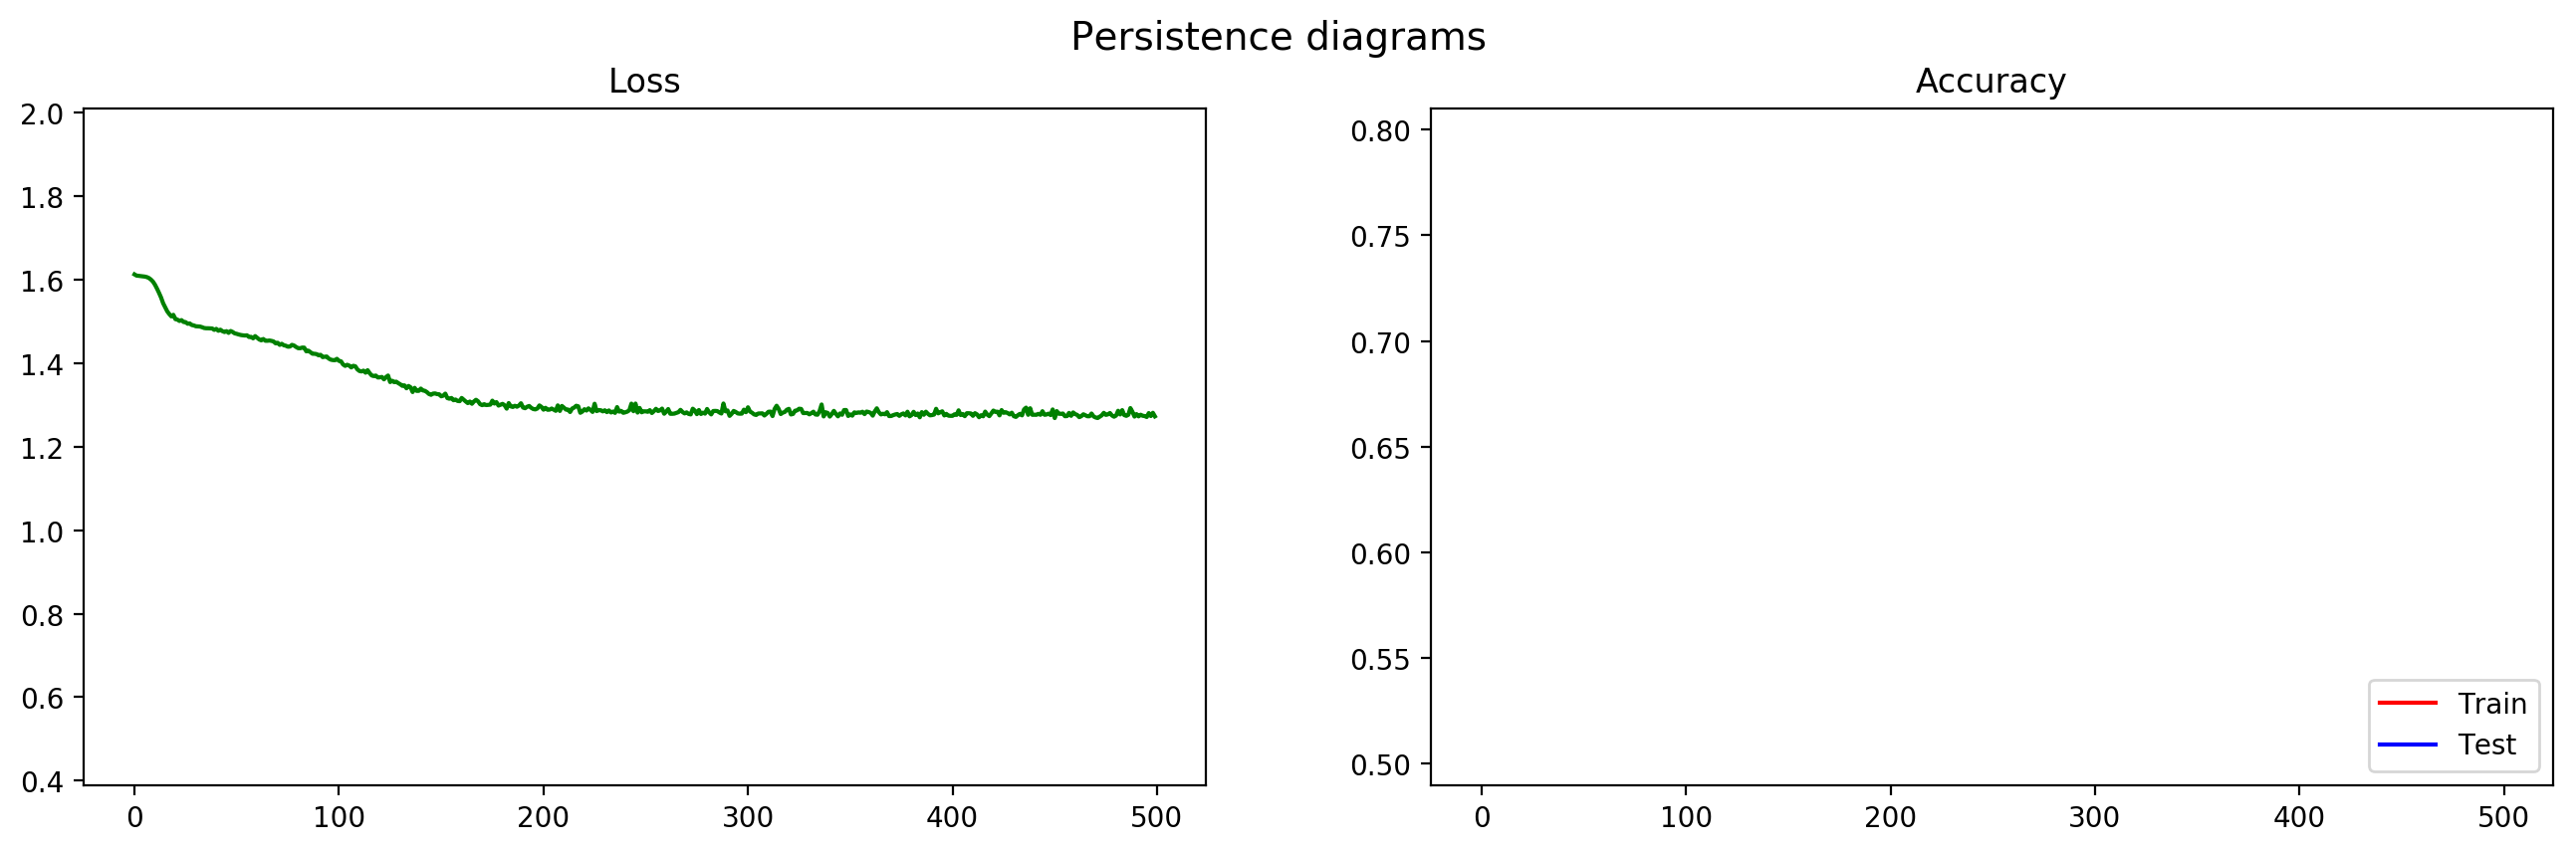

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams", fontsize=14)
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_ylim(0.39, 2.01)
ax[1].set_ylim(0.49, 0.81)
ax[0].plot(history.mean(axis=0)[:,0], c="g")
ax[0].fill_between(x, loss_ci1, loss_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:,1], c="r", label="Train")
ax[1].plot(history.mean(axis=0)[:,2], c="b", label="Test")
ax[1].fill_between(x, acc_train_ci1, acc_train_ci2, color="r", alpha=0.1)
ax[1].fill_between(x, acc_test_ci1, acc_test_ci2, color="b", alpha=0.1)
ax[1].legend(loc=4)
plt.show()

In [ ]:
torch.save(model.state_dict(), "linear_classification_baseline_orbit5k.pt")